# Advanced ML Part II // Lecture 04 Scratch // includes "from mnist to svhn"

In [43]:
# written by John P. Cunningham, for use in lecture
# continues many of the conventions set out in Wenda Zhou's excellent tf tutorial
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio

### Some helper functions

In [44]:
def plot_save(x, fname='foo.png', extent=None, show=True, cmap='gray'):
    plt.imshow(x,cmap=cmap,extent=extent)
    plt.axis('off')
    plt.savefig('tmp/'+fname,bbox_inches='tight')
    if show:
        plt.show()

In [45]:
# evaluate performance on some data 
def perf_eval(logit_pred, y_true):
    """a function to evaluate performance of predicted y values vs true class labels"""
    # now look at some data
    print('    sample pred: {0}\n    sample true: {1}'.format(np.argmax(logit_pred[0:20],1),np.argmax(y_true[0:20],1)))
    # avg accuracy
    is_correct_vals = np.equal(np.argmax(logit_pred,1),np.argmax(y_true,1))
    #accuracy_vals = np.mean(is_correct_vals)
    #print('    mean classification accuracy: {0}%'.format(100*accuracy_vals))
    # Dig in a little deeper.  Where did we make correct predictions?  Does this seem reasonable?
    print('    correct predictions by class: {0}'.format(y_true[is_correct_vals,:].sum(axis=0)))

### Load and sample the data

In [46]:
# load SVHN data; get it yourself from http://ufldl.stanford.edu/housenumbers/
mat_train = spio.loadmat('../data/svhn/train_32x32.mat')
mat_test = spio.loadmat('../data/svhn/test_32x32.mat')
mat_train.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [47]:
mean_subtract=1
n_val = 5000
[inh,inw,inc,n] = mat_train['X'].shape
#[_,_,_,n_test] = mat_test['X'].shape
X_train = np.empty(shape=(inh,inw,inc,n-n_val), dtype=np.float32)
X_val = np.empty(shape=(inh,inw,inc,n_val), dtype=np.float32)
if mean_subtract==1:
    for i in range(n-n_val):
        for c in range(3):
            X_train[:,:,c,i] = (mat_train['X'][:,:,c,i] - np.mean(mat_train['X'][:,:,c,i]))/255
    for i in range(n_val):
        for c in range(3):
            X_val[:,:,c,i] = (mat_train['X'][:,:,c,i-n_val] - np.mean(mat_train['X'][:,:,c,i-n_val]))/255
            
else:
    X_train = mat_train['X'][:,:,:,:n-n_val]
    X_val = mat_train['X'][:,:,:,-n_val:]

In [48]:
# unusual labeling scheme...
print(np.unique(mat_train['y']))
print(mat_train['y'][63900])
# recode this in our usual way
y_train0 = np.array([0 if y==10 else y[0] for y in mat_train['y'][:n-n_val]]).reshape([n-n_val,1])
print(np.unique(y_train0))
print(y_train0[63900])

[ 1  2  3  4  5  6  7  8  9 10]
[10]
[0 1 2 3 4 5 6 7 8 9]
[0]


In [49]:
# now format y data correctly
y_train = mat_train['y']
# basic sanity check!  Uh oh...
print(y_train[63900])
print(np.unique(y_train))
# fix this... note goofy bit about reshaping to (n, 1) to avoid (n,) shape issues
y_train0 = np.array([0 if y==10 else y[0] for y in mat_train['y'][:n-n_val]]).reshape([n-n_val,1])
y_vals = np.unique(y_train0).size
# encode y as one hot vectors
y_onehot = (np.arange(y_vals) == y_train0).astype(int)
# y_onehot[63900,:] # check to make sure
print(y_train0[63900])
print(np.unique(y_train0))
print(y_onehot[63900,:])
print(np.sum(y_onehot,0))
y_train = y_train0
# and same for test
y_val = np.array([0 if y==10 else y[0] for y in mat_train['y'][-n_val:]]).reshape([n_val,1])
y_onehot_val = (np.arange(np.unique(y_val).size) == y_val).astype(int)

[10]
[ 1  2  3  4  5  6  7  8  9 10]
[0]
[0 1 2 3 4 5 6 7 8 9]
[1 0 0 0 0 0 0 0 0 0]
[ 4622 12931  9884  7897  6972  6379  5315  5218  4690  4349]


In [50]:
plot_save(X_train[:,:,:,153], 'svhn_digit_0', cmap=None, show=False)
plot_save(X_train[:,:,:,2], 'svhn_digit_1', cmap=None, show=False)
plot_save(X_train[:,:,:,5000], 'svhn_digit_2', cmap=None, show=False)
plot_save(X_train[:,:,:,341], 'svhn_digit_3', cmap=None, show=False)

The shape of the X_train tensor is: (32, 32, 3, 68257)
The label data has the following unique labels: [0 1 2 3 4 5 6 7 8 9]
Below is a sample data point (indexed by the LAST dimension of the tensor):


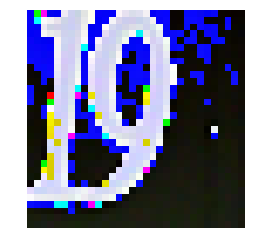

Its label is [9] and its onehot encoding is [0 0 0 0 0 0 0 0 0 1].
The third index is the color channel (as you can see by permuting those indices)


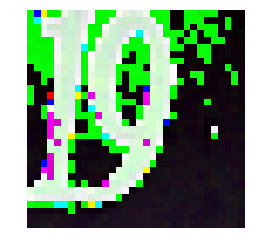

In [51]:
# one critical thing to realize is that tf interprets the shape of tensors to mean very specific things.
# Being careless with this fact can cause substantial problems.
# Let's understand the shape a bit.
print('The shape of the X_train tensor is: {0}'.format(X_train.shape))
print('The label data has the following unique labels: {0}'.format(np.unique(y_train)))
print('Below is a sample data point (indexed by the LAST dimension of the tensor):')
mm = 1
plot_save(X_train[:,:,:,mm], 'svhn_c1')
print('Its label is {0} and its onehot encoding is {1}.'.format(y_train[mm],y_onehot[mm]))
print('The third index is the color channel (as you can see by permuting those indices)')
plot_save(X_train[:,:,[0,2,1],mm], 'svhn_c2')  # for example

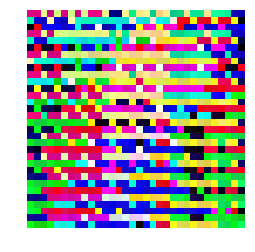

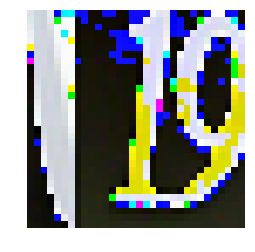

In [52]:
# this matters because we will take a batch of data, say the following samples:
batch = [0,1,2]
# and we will then reshape this data, as in:
x_re = X_train[:,:,:,batch].reshape([np.shape(batch)[0],-1])
# tf will then take this data one at a time from the first index.  
xim = x_re[0,:]
# let us reshape and plot that to make sure it is correct
plot_save(xim.reshape([32,32,3]), 'svhn_c3')
# ugh that is not right...
# so we need to thoughtfully permute the indices of the tensor.  Get used to this and be careful.
plot_save(X_train[:,:,:,batch].transpose([3,0,1,2]).reshape([np.shape(batch)[0],-1])[0,:].reshape([32,32,3]), 'svhn_c4')
# better...

### Build models

In [53]:
# cnn conv stuff
def conv(x, W):
    """simple wrapper for tf.nn.conv2d"""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def maxpool(x):
    """simple wrapper for tf.nn.max_pool with stride size 2"""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def norm(x): 
    """simple wrapper for tf.nn.lrn... See section 3.3 of Krizhevsky 2012 for details"""
    return tf.nn.lrn(x, depth_radius=5, bias=2, alpha=1e-4, beta=0.75)

In [54]:
# elaborate the compute_logits code to include a variety of models
def compute_logits(x, model_type, pkeep):
    """Compute the logits of the model"""
    if model_type=='lr':
        W = tf.get_variable('W', shape=[32*32*3, 10])
        b = tf.get_variable('b', shape=[10])
        logits = tf.add(tf.matmul(x, W), b, name='logits_lr')
    elif model_type=='cnn_cf':
        # try a 1 layer cnn
        n1 = 64
        x_image = tf.reshape(x, [-1,32,32,3]) # batch, then width, height, channels
        # cnn layer 1
        W_conv1 = tf.get_variable('W_conv1', shape=[5, 5, 3, n1])
        b_conv1 = tf.get_variable('b_conv1', shape=[n1])
        h_conv1 = tf.nn.relu(tf.add(conv(x_image, W_conv1), b_conv1))
        # fc layer to logits
        h_conv1_flat = tf.reshape(h_conv1, [-1, 32*32*n1])
        W_fc1 = tf.get_variable('W_fc1', shape=[32*32*n1, 10])
        b_fc1 = tf.get_variable('b_fc1', shape=[10])
        logits = tf.add(tf.matmul(h_conv1_flat, W_fc1), b_fc1, name='logits_cnn_cf')
    elif model_type=='cnn_cnf':
        # try a 1 layer cnn with a normalization layer
        n1 = 64
        x_image = tf.reshape(x, [-1,32,32,3]) # batch, then width, height, channels
        # cnn layer 1
        W_conv1 = tf.get_variable('W_conv1', shape=[5, 5, 3, n1])
        b_conv1 = tf.get_variable('b_conv1', shape=[n1])
        h_conv1 = tf.nn.relu(tf.add(conv(x_image, W_conv1), b_conv1))
        # norm layer 1
        h_norm1 = norm(h_conv1)
        # fc layer to logits
        h_flat = tf.reshape(h_norm1, [-1, 32*32*n1])
        W_fc1 = tf.get_variable('W_fc1', shape=[32*32*n1, 10])
        b_fc1 = tf.get_variable('b_fc1', shape=[10])
        logits = tf.add(tf.matmul(h_flat, W_fc1), b_fc1, name='logits_cnn_cnf')     
    elif model_type=='cnn_cpncpnff':
        # 2 layer cnn
        n1 = 32
        n2 = 64
        n3 = 1024
        x_image = tf.reshape(x, [-1,32,32,3]) # batch, then width, height, channels
        # cnn layer 1
        W_conv1 = tf.get_variable('W_conv1', shape=[5, 5, 3, n1])
        b_conv1 = tf.get_variable('b_conv1', shape=[n1])
        h_conv1 = tf.nn.relu(tf.add(conv(x_image, W_conv1), b_conv1))
        # pool 1
        h_pool1 = maxpool(h_conv1)
        # norm 1
        h_norm1 = norm(h_pool1)
        # cnn layer 2
        W_conv2 = tf.get_variable('W_conv2', shape=[5, 5, n1, n2])
        b_conv2 = tf.get_variable('b_conv2', shape=[n2])
        h_conv2 = tf.nn.relu(tf.add(conv(h_norm1, W_conv2), b_conv2))
        # pool 2
        h_pool2 = maxpool(h_conv2)
        # norm 2
        h_norm2 = norm(h_pool2)
        # fc layer to logits (8x8 since 2 rounds of maxpool)
        h_norm2_flat = tf.reshape(h_norm2, [-1, 8*8*n2])
        W_fc1 = tf.get_variable('W_fc1', shape=[8*8*n2, n3])
        b_fc1 = tf.get_variable('b_fc1', shape=[n3])
        h_fc1 = tf.nn.relu(tf.add(tf.matmul(h_norm2_flat, W_fc1), b_fc1))
        # one more fc layer
        # ... again, this is the logistic layer with softmax readout
        W_fc2 = tf.get_variable('W_fc2', shape=[n3,10])
        b_fc2 = tf.get_variable('b_fc2', shape=[10])
        logits = tf.add(tf.matmul(h_fc1, W_fc2), b_fc2, name='logits_cnn_cpncpnff')
    elif model_type=='cnn_cpncpnfdf':
        # same as above but add dropout.
        # 2 layer cnn
        n1 = 32
        n2 = 64
        n3 = 1024
        x_image = tf.reshape(x, [-1,32,32,3]) # batch, then width, height, channels
        # cnn layer 1
        W_conv1 = tf.get_variable('W_conv1', shape=[5, 5, 3, n1])
        b_conv1 = tf.get_variable('b_conv1', shape=[n1])
        h_conv1 = tf.nn.relu(tf.add(conv(x_image, W_conv1), b_conv1))
        # pool 1
        h_pool1 = maxpool(h_conv1)
        # norm 1
        h_norm1 = norm(h_pool1)
        # cnn layer 2
        W_conv2 = tf.get_variable('W_conv2', shape=[5, 5, n1, n2])
        b_conv2 = tf.get_variable('b_conv2', shape=[n2])
        h_conv2 = tf.nn.relu(tf.add(conv(h_norm1, W_conv2), b_conv2))
        # pool 2
        h_pool2 = maxpool(h_conv2)
        # norm 2
        h_norm2 = norm(h_pool2)
        # fc layer to logits (8x8 since 2 rounds of maxpool)
        h_norm2_flat = tf.reshape(h_norm2, [-1, 8*8*n2])
        W_fc1 = tf.get_variable('W_fc1', shape=[8*8*n2, n3])
        b_fc1 = tf.get_variable('b_fc1', shape=[n3])
        h_fc1 = tf.nn.relu(tf.add(tf.matmul(h_norm2_flat, W_fc1), b_fc1))
        # insert a dropout layer here.
        h_fc1_drop = tf.nn.dropout(h_fc1, pkeep)
        # one more fc layer
        # ... again, this is the logistic layer with softmax readout
        W_fc2 = tf.get_variable('W_fc2', shape=[n3,10])
        b_fc2 = tf.get_variable('b_fc2', shape=[10])
        logits = tf.add(tf.matmul(h_fc1_drop, W_fc2), b_fc2, name='logits_cnn_cpncpnfdf')
    else: 
        print('error not a valid model type')

    return logits

def compute_cross_entropy(logits, y):
    # Compute the average cross-entropy across all the examples.
    numerical_instability_example = 0
    if numerical_instability_example:
        y_pred = tf.nn.softmax(logits, name='y_pred') # the predicted probability for each example.
        cross_ent = tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_pred), reduction_indices=[1]))
    else:
        sm_ce = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=logits, name='cross_ent_terms')
        cross_ent = tf.reduce_mean(sm_ce, name='cross_ent')
    return cross_ent

def compute_accuracy(logits, y):
    prediction = tf.argmax(logits, 1, name='pred_class')
    true_label = tf.argmax(y, 1, name='true_class')
    accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, true_label), tf.float32))
    return accuracy

### Run models

In [55]:
# choose case to run 
opt_method = 'sgd'
model_type = 'lr' 
dir_name = 'logs/scratch04x/{}_{}_ms{}'.format(model_type, opt_method, mean_subtract)
batch_size = 100

In [56]:
with tf.Graph().as_default():
    # We build the model here as before
    x = tf.placeholder(tf.float32, [None, 32*32*3], name='x')
    y = tf.placeholder(tf.float32, [None, 10], name='y')
    pkeep = tf.placeholder(tf.float32, name='pkeep')
    
    with tf.name_scope('model'):
        logits = compute_logits(x, model_type, pkeep)
    with tf.name_scope('loss'):
        loss = compute_cross_entropy(logits=logits, y=y)
    with tf.name_scope('accuracy'):
        accuracy = compute_accuracy(logits, y)
    
    with tf.name_scope('opt'):
        if opt_method == 'sgd':
            opt = tf.train.GradientDescentOptimizer(0.5)
        elif opt_method == 'rms':
            opt = tf.train.RMSPropOptimizer(.001)
        elif opt_method == 'adam':
            opt = tf.train.AdamOptimizer(1e-4)
        train_step = opt.minimize(loss)
    
    with tf.name_scope('summaries'):
        # create summary for loss and accuracy
        tf.summary.scalar('loss', loss) 
        tf.summary.scalar('accuracy', accuracy)
        # create summary for logits
        tf.summary.histogram('logits', logits)
        # create summary for input image
        tf.summary.image('input', tf.reshape(x, [-1, 32, 32, 3]))
    
        summary_op = tf.summary.merge_all()
    
    with tf.Session() as sess:
        summary_writer = tf.summary.FileWriter(dir_name, sess.graph)
        summary_writer_train = tf.summary.FileWriter(dir_name+'/train', sess.graph)
        summary_writer_val = tf.summary.FileWriter(dir_name+'/val')
        
        sess.run(tf.global_variables_initializer())
    
        for i in range(20001):
            batch = np.floor(np.random.rand(batch_size)*(n-n_val)).astype(int)
            X_batch = X_train[:,:,:,batch].transpose([3,0,1,2]).reshape([batch_size,-1])
            y_batch = y_onehot[batch]

            # now run
            _ , summary = sess.run((train_step, summary_op),
                                      feed_dict={x: X_batch, y: y_batch, pkeep:0.85})
            
            # write the summary output to file
            if i%100==0:
                summary_writer_train.add_summary(summary, i)

            # print diagnostics
            if i%100 == 0:
                X_batch = X_train[:,:,:,0:1000].transpose([3,0,1,2]).reshape([1000,-1])
                y_batch = y_onehot[0:1000]
                (train_error,train_logits) = sess.run((accuracy,logits), {x: X_batch, y: y_batch, pkeep:1.0})
                print("\rStep {0:3d}: training accuracy {1:0.4f}".format(i, train_error), flush=True)
                # further diagnostics
                perf_eval(train_logits, y_batch)
                
            if i%100 == 0:
                X_batch = X_val.transpose([3,0,1,2]).reshape([n_val,-1])
                y_batch = y_onehot_val
                (val_error, summary) = sess.run((accuracy,summary_op), {x:X_batch, y:y_batch, pkeep:1.0})
                print("\rStep {0:3d}: val accuracy {1:0.4f}".format(i, val_error), flush=True)
                summary_writer_val.add_summary(summary, i)


Step   0: training accuracy 0.0580
    sample pred: [0 8 3 3 0 8 8 8 8 3 8 0 3 0 8 8 3 0 8 3]
    sample true: [1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8]
    correct predictions by class: [15  0  2 15  0  0  0  0 25  1]
Step   0: val accuracy 0.0758
Step 100: training accuracy 0.2090
    sample pred: [1 1 1 1 1 3 1 3 1 1 1 1 1 1 1 1 4 1 1 4]
    sample true: [1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8]
    correct predictions by class: [  6 126  30  12  13   9   6   3   4   0]
Step 100: val accuracy 0.2170
Step 200: training accuracy 0.2450
    sample pred: [2 1 3 2 1 3 1 8 3 2 2 1 3 1 1 1 4 1 1 4]
    sample true: [1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8]
    correct predictions by class: [ 16 118  31  23  34  13   3   0   7   0]
Step 200: val accuracy 0.2476
Step 300: training accuracy 0.2470
    sample pred: [3 9 2 2 2 3 1 3 2 3 1 2 3 1 3 1 4 1 2 1]
    sample true: [1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8]
    correct predictions by class: [  9 106  45  29  29  17   3   1   5   3]
Step

Step 3200: training accuracy 0.2860
    sample pred: [3 1 2 2 1 5 1 3 2 1 2 4 2 1 2 4 4 2 2 1]
    sample true: [1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8]
    correct predictions by class: [  6 110  50  33  39  27   5   7   6   3]
Step 3200: val accuracy 0.2648
Step 3300: training accuracy 0.2670
    sample pred: [5 1 2 1 1 3 1 3 2 1 1 4 2 1 3 1 4 2 2 1]
    sample true: [1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8]
    correct predictions by class: [  3 116  56  35  26  10   6   9   5   1]
Step 3300: val accuracy 0.2556
Step 3400: training accuracy 0.2620
    sample pred: [3 1 2 1 2 8 1 2 1 1 2 1 1 1 3 4 4 1 2 0]
    sample true: [1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8]
    correct predictions by class: [  6 115  55  21  29  16   9   5   3   3]
Step 3400: val accuracy 0.2512
Step 3500: training accuracy 0.2510
    sample pred: [3 1 2 1 1 3 1 3 1 1 1 1 1 1 1 1 1 1 1 1]
    sample true: [1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8]
    correct predictions by class: [  5 111  47  23  26  20   8 

Step 6400: training accuracy 0.2760
    sample pred: [3 4 2 2 1 8 1 3 1 1 1 1 1 1 1 1 1 2 2 1]
    sample true: [1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8]
    correct predictions by class: [  9 125  50  31  22  19   6   6   8   0]
Step 6400: val accuracy 0.2492
Step 6500: training accuracy 0.2980
    sample pred: [3 1 2 1 1 7 1 1 2 1 2 2 2 1 1 4 4 2 2 1]
    sample true: [1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8]
    correct predictions by class: [ 12 122  66  20  31  27   8   7   3   2]
Step 6500: val accuracy 0.2648
Step 6600: training accuracy 0.2700
    sample pred: [3 1 2 2 1 3 1 3 1 1 1 1 1 1 1 4 6 1 2 1]
    sample true: [1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8]
    correct predictions by class: [  9 129  44  22  15  14  14   7   9   7]
Step 6600: val accuracy 0.2536
Step 6700: training accuracy 0.2720
    sample pred: [3 1 2 1 1 3 1 6 1 1 1 1 3 1 1 4 6 1 1 6]
    sample true: [1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8]
    correct predictions by class: [ 10 118  44  21  31  21  13 

Step 9600: training accuracy 0.3020
    sample pred: [3 1 6 2 2 5 1 3 2 1 2 2 2 1 2 4 4 2 2 8]
    sample true: [1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8]
    correct predictions by class: [ 10 115  53  35  34  29   9   4   9   4]
Step 9600: val accuracy 0.2604
Step 9700: training accuracy 0.2740
    sample pred: [3 4 2 2 1 3 1 5 2 1 1 2 3 1 1 4 6 2 2 1]
    sample true: [1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8]
    correct predictions by class: [ 11 100  44  32  30  17  10  11  11   8]
Step 9700: val accuracy 0.2584
Step 9800: training accuracy 0.3020
    sample pred: [3 1 2 2 1 5 1 5 2 1 1 2 2 1 1 4 4 1 2 1]
    sample true: [1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8]
    correct predictions by class: [  9 130  49  23  37  20  12   9   7   6]
Step 9800: val accuracy 0.2654
Step 9900: training accuracy 0.3010
    sample pred: [3 1 2 2 1 5 1 3 1 1 1 1 3 5 1 4 4 2 2 1]
    sample true: [1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8]
    correct predictions by class: [ 14 119  52  18  42  27   9 

Step 12800: training accuracy 0.2870
    sample pred: [3 1 2 1 2 3 1 3 2 1 2 2 1 1 1 4 6 1 2 0]
    sample true: [1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8]
    correct predictions by class: [ 12 112  48  30  37  23  13   5   5   2]
Step 12800: val accuracy 0.2516
Step 12900: training accuracy 0.2870
    sample pred: [3 1 1 1 2 8 1 3 1 1 2 1 3 1 1 1 4 1 2 0]
    sample true: [1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8]
    correct predictions by class: [  8 131  48  22  32  16   9   6  11   4]
Step 12900: val accuracy 0.2736
Step 13000: training accuracy 0.2840
    sample pred: [3 1 2 9 2 3 1 3 2 1 2 1 2 1 3 4 4 1 2 8]
    sample true: [1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8]
    correct predictions by class: [  8 135  50  18  34  13   8   8   9   1]
Step 13000: val accuracy 0.2690
Step 13100: training accuracy 0.2780
    sample pred: [3 4 2 2 2 3 1 8 1 1 2 2 2 1 1 1 1 1 1 0]
    sample true: [1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8]
    correct predictions by class: [ 11 117  53  24  24  

Step 16000: training accuracy 0.2870
    sample pred: [3 1 2 1 1 8 1 8 1 7 1 4 1 1 1 4 4 1 2 7]
    sample true: [1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8]
    correct predictions by class: [  7 119  47  23  38  18  10   9  11   5]
Step 16000: val accuracy 0.2560
Step 16100: training accuracy 0.2680
    sample pred: [3 1 2 1 2 5 1 9 1 1 1 1 1 1 1 1 1 1 2 1]
    sample true: [1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8]
    correct predictions by class: [  8 117  51  27  19  17   7   9   6   7]
Step 16100: val accuracy 0.2554
Step 16200: training accuracy 0.2830
    sample pred: [5 1 2 2 1 5 1 3 8 9 1 1 8 1 3 1 1 1 2 1]
    sample true: [1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8]
    correct predictions by class: [  9 133  46  27  24  17   7   4  11   5]
Step 16200: val accuracy 0.2496
Step 16300: training accuracy 0.2770
    sample pred: [3 1 2 2 1 8 1 3 1 1 1 1 3 1 1 1 4 2 2 1]
    sample true: [1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8]
    correct predictions by class: [  8 119  57  27  24  

Step 19200: training accuracy 0.2950
    sample pred: [3 4 3 9 1 5 1 1 9 1 2 4 3 1 1 4 4 2 2 1]
    sample true: [1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8]
    correct predictions by class: [ 16 129  41  32  32  16  10   8   6   5]
Step 19200: val accuracy 0.2672
Step 19300: training accuracy 0.2660
    sample pred: [3 4 3 1 1 8 1 3 1 1 1 1 5 1 1 1 1 2 1 1]
    sample true: [1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8]
    correct predictions by class: [  6 126  42  25  20  20  10   7   8   2]
Step 19300: val accuracy 0.2550
Step 19400: training accuracy 0.2840
    sample pred: [3 1 1 2 1 3 1 9 2 2 1 1 3 1 3 4 4 1 1 5]
    sample true: [1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8]
    correct predictions by class: [ 14 114  39  28  35  17  17   8   7   5]
Step 19400: val accuracy 0.2594
Step 19500: training accuracy 0.2830
    sample pred: [3 4 2 1 1 1 1 5 1 1 1 1 1 1 1 4 1 2 1 1]
    sample true: [1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8]
    correct predictions by class: [ 11 117  47  24  34  

### Slide extras; no didactic purpose

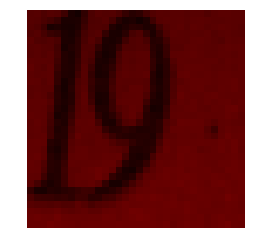

In [57]:
# plot different color channels 
showr = np.zeros_like(mat_train['X'][:,:,:,1])
showr[:,:,0] = mat_train['X'][:,:,0,1]
plot_save(showr, 'svhn_digit_0x', cmap=None, show=True)